# A Beginner's Guide to Using DuckDB with Stock Price Data in R

In this blog post, I will demonstrate how to work with stock price data using the [DuckDB](https://duckdb.org/) database management system in R. 

DuckDB is a fast and lightweight analytical database engine that is designed to work with various programming languages, including R. You can use Duck DB from the command line or from a client library for your favourite language. In this areticle, I'll use the R client library. 

I will cover the following topics:

- Why would we even want to use a database, and what are the drawbacks? (spoiler alert: DuckDB eliminates nearly all of these)
- Installing DuckDB and loading the R package
- Connecting to DuckDB and creating a database
- Importing stock price data
- Querying and analyzing the data



## Why use a database? What are the drawbacks? 

Let me give you some reasons why a database might be better than managing data in say flat files:

- Databases are like neatly organized shelves, where everything has its place, making it easy to find and relate different bits of information. Flat files, however, are more like a big pile of papers, where finding something can be a challenge.
- Databases make it simple to search and filter your data, kind of like having a super-smart assistant who knows exactly where everything is. With flat files, you’d have to go through everything manually, which can be time-consuming and tedious.
- Databases have built-in checks to make sure your data stays consistent and reliable. Flat files rely more on you doing the checking and cleaning yourself.
- Databases can handle large amounts of data efficiently. Flat files may become more chaotic and unruly as data size grows.
- Databases use clever tricks to make searching and processing data faster. Flat files lack these optimizations, which can make them sluggish as your data piles up.

Of course, there’s no free lunch. If we were to use a database, there’d of course be some tradeoffs. 

- Databases can be a bit more complex to set up and configure than flat files. 
- Databases often require some knowledge of their query language, like learning a new way to communicate. Flat files, on the other hand, require no new lingo.
- Databases can sometimes be more resource-intensive, taking up more memory and processing power. Flat files are like traveling light, with just the essentials in your backpack.
- Databases come with a lot of bells and whistles, which might be overkill for small projects or simple tasks. 
- Flat files are simple text or binary files, which can be easily opened and read by almost any software. Databases might require specific tools or drivers to access and manage the data.
- Databases store data in a structured, binary format, which is not easily readable by humans. Flat files, being plain text or simple binary formats, can be more accessible and easier to understand at a glance.

### DuckDB: Advantages without the Trade-Offs

DuckDB tries to maximise the benefits of using a database while minimising the trade-offs. I think it does a really good job of this. 

DuckDB is a lightweight and fast database system that you can just plug into an application or code base and start using right away. I’ve been using it for a couple of weeks now, and it feels more like a really smart data assistant than a database. By that I mean that it requires literally zero setup and ongoing management – it just gives you the data you want with minimal effort on your part. 

One of the best things about DuckDB is that it’s embedded, meaning it’s a part of your application and doesn’t need a separate server or process. For example, you can use it from within an R session using its R client library. The same is true for Python, C++ and many other languages. So you can use it to easily run queries over datasets that won’t fit into memory using familiar data analysis tools. 

DuckDB is also super fast when it comes to crunching numbers and analyzing data. It’s specifically designed for analytics workflows. In the work I’ve been doing recently, I did some updates on the data using DuckDB and found that it performed similarly to a SQL-lite database. But when I simply *queried* the data, it was lightning fast. 

## 1. Install and load

Installing duckdb and loading the R library is simple. 

I'll also load the tidyverse library and show you how to use it to query the database. 

In [3]:
#' Function for checking if a package is installed, and installing it if not
install <- function(packages) {
  to_install <- packages[which(!packages %in% rownames(installed.packages()))]
  install.packages(to_install)
}

In [6]:
install(packages = c("duckdb", "tidyverse", "stringr"))

library(duckdb)
library(tidyverse)
library(stringr)

## 2. Read in data from csv files

In this example, we'll read in some stock price data from CSVs that live in GitHub. 

For the sake of the example, we'll:
- Create an in-memory DuckDB
- Read each csv file into a dataframe
- Write the dataframe to a table in our DuckDB called "prices"
- Remove the dataframe from our R session so that we can only work with the DuckDB

I'm making an in-memory DuckDB just for the sake of the example, and this only exists for the life of my R session, or until I disconnect from it. But I'll also show you how to make one that persists on disk and that you can reconnect to later. 

In this example, we're only using "small" data, but this approach really shines when you have loads of data that you don't want to load into memory. Using DuckDB, you can easily and quickly query it on disk. 

In [34]:
# list of URLs containing our csv files
base_url <- "https://raw.githubusercontent.com/Robot-Wealth/r-quant-recipes/master/data/"
stocks <- c("AAPL", "BA", "CAT", "IBM", "MSFT")
urls <- str_glue("{base_url}{stocks}.csv")

# read data into a dataframe
prices_df <- urls %>% 
    map_dfr(read_csv, col_types = "Dddddddc") %>% 
    arrange(Date, Ticker)
    
head(prices_df)

Date,Open,High,Low,Close,Adj Close,Volume,Ticker
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2009-12-31,7.611786,7.619643,7.520,7.526071,6.405576,352410800,AAPL
2009-12-31,55.000000,55.220001,54.050,54.130001,42.180111,2189400,BA
2009-12-31,57.599998,57.959999,56.990,56.990002,39.844051,3859700,CAT
2009-12-31,126.586998,127.007645,125.000,125.143402,79.387985,4417676,IBM
2009-12-31,30.980000,30.990000,30.480,30.480000,23.265152,31929700,MSFT
2010-01-04,7.622500,7.660714,7.585,7.643214,6.505280,493729600,AAPL


In [36]:
# make an in-memory db and store the connection in a variable
con <- dbConnect(duckdb::duckdb())  

# to make a persistent db on disk (and to connect to it again later) do:
# con <- dbConnect(duckdb::duckdb(dbdir = "/path/to/db/location/mydatabase.duckdb"))  

# write our prices data to duckdb table
table_name <- "prices"
duckdb::dbWriteTable(con, table_name, prices_df)

# remove prices_df
rm(prices_df)

## 3. Query some data in our db

We can use `tidyverse` operations to query the DuckDB directly. 

If you pass `dplyr::tbl` the `DBIConnection` object we created above (`con`) and the name of the table you want to query, you'll get a reference to that table. You can then query it without bringing data back into your R session.

In fact, this approach will *only* bring data back into your R session if you explicitly ask for it using the `collect` function, which I'll show you shortly. 

Here's how you could get the number of records, the earliest record, and the latest record for each ticker without bringing any data in your R session:

In [40]:
tbl(con, "prices") %>% 
  group_by(Ticker) %>% 
  summarise(
    Count = n(),
    From = first(Date),
    To = last(Date)
  )

# Source:   SQL [5 x 4]
# Database: DuckDB 0.7.1 [Kris@Windows 10 x64:R 4.2.3/:memory:]
  Ticker Count From       To        
  <chr>  <dbl> <date>     <date>    
1 AAPL    3354 2009-12-31 2023-04-28
2 BA      3354 2009-12-31 2023-04-28
3 CAT     3354 2009-12-31 2023-04-28
4 IBM     3354 2009-12-31 2023-04-28
5 MSFT    3354 2009-12-31 2023-04-28

Notice the metadata you get with the output above. The source is a SQL table in an in-memory DuckDB. 

You can also send SQL to be executed on the database. If you want to get the result back in your R session, use `dbGetQuery`, otherwise use `dbSendQuery`:


In [41]:
result <- dbGetQuery(con, paste0("SELECT * FROM prices LIMIT 5"))
result

Date,Open,High,Low,Close,Adj Close,Volume,Ticker
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2009-12-31,7.611786,7.619643,7.52,7.526071,6.405576,352410800,AAPL
2009-12-31,55.000000,55.220001,54.05,54.130001,42.180111,2189400,BA
2009-12-31,57.599998,57.959999,56.99,56.990002,39.844051,3859700,CAT
2009-12-31,126.586998,127.007645,125.00,125.143402,79.387985,4417676,IBM
2009-12-31,30.980000,30.990000,30.48,30.480000,23.265152,31929700,MSFT


You can do the operation above by writing an equivalent `dplyr` operation and piping it into `collect`:

In [42]:
tbl(con, "prices") %>% 
  head(5) %>% 
  collect()

Date,Open,High,Low,Close,Adj Close,Volume,Ticker
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2009-12-31,7.611786,7.619643,7.52,7.526071,6.405576,352410800,AAPL
2009-12-31,55.000000,55.220001,54.05,54.130001,42.180111,2189400,BA
2009-12-31,57.599998,57.959999,56.99,56.990002,39.844051,3859700,CAT
2009-12-31,126.586998,127.007645,125.00,125.143402,79.387985,4417676,IBM
2009-12-31,30.980000,30.990000,30.48,30.480000,23.265152,31929700,MSFT


Under the hood, `dplyr` is translating it's operations into SQL. However, some operations don't translate easily - particularly window operations (eg moving average) and some functions that aggregate across rows (eg mean). 

For these we'd need to execute actual SQL or rewrite our queries to be more SQL-friendly:

In [49]:
# Basic TWAP approximation

# won't work
# tbl(con, "prices") %>% 
#    dplyr::mutate(TWAP = mean(c(Open, High, Low, Close))) %>% 
#    head()
  
# will work
tbl(con, "prices") %>% 
   dplyr::mutate(TWAP = (Open + High + Low + Close)/4) %>% 
   head()

# Source:   SQL [6 x 9]
# Database: DuckDB 0.7.1 [Kris@Windows 10 x64:R 4.2.3/:memory:]
  Date         Open   High    Low  Close `Adj Close`    Volume Ticker   TWAP
  <date>      <dbl>  <dbl>  <dbl>  <dbl>       <dbl>     <dbl> <chr>   <dbl>
1 2009-12-31   7.61   7.62   7.52   7.53        6.41 352410800 AAPL     7.57
2 2009-12-31  55     55.2   54.0   54.1        42.2    2189400 BA      54.6 
3 2009-12-31  57.6   58.0   57.0   57.0        39.8    3859700 CAT     57.4 
4 2009-12-31 127.   127.   125    125.         79.4    4417676 IBM    126.  
5 2009-12-31  31.0   31.0   30.5   30.5        23.3   31929700 MSFT    30.7 
6 2010-01-04   7.62   7.66   7.58   7.64        6.51 493729600 AAPL     7.63

## 5. Updating data in the DuckDB

Here's a 60-day moving average calculation in SQL (this wouldn't work if I tried to do it in R) that updates the `prices` table. 

In this case I want to update the actual table in the DuckDB. To do that, I need to use `DBI::dbExecute` rather than `DBI::dbSendQuery`. Also, I can't do this with `dplyr` since it can't update data in the table. 

`dbExecute` returns the number of affected rows:

In [ ]:
# 60-day moving average
affected_rows <- dbExecute(con, 
    'ALTER TABLE prices ADD COLUMN IF NOT EXISTS MA60 DOUBLE;
     UPDATE prices SET MA60 = t2.MA60
     FROM (
        SELECT Ticker, Date, AVG("Adj Close") OVER (
            PARTITION BY Ticker ORDER BY Date ROWS BETWEEN 59 PRECEDING AND CURRENT ROW
        ) AS MA60
    FROM prices
    ) t2
WHERE prices.Ticker = t2.Ticker AND prices.Date = t2.Date;'
)

affected_rows

[1] 16770

An extra column (MA60) has been added to the table:

In [60]:
tbl(con, "prices") %>% head()

# Source:   SQL [6 x 9]
# Database: DuckDB 0.7.1 [Kris@Windows 10 x64:R 4.2.3/:memory:]
  Date         Open   High    Low  Close `Adj Close`    Volume Ticker  MA60
  <date>      <dbl>  <dbl>  <dbl>  <dbl>       <dbl>     <dbl> <chr>  <dbl>
1 2009-12-31   7.61   7.62   7.52   7.53        6.41 352410800 AAPL    6.41
2 2009-12-31  55     55.2   54.0   54.1        42.2    2189400 BA     42.2 
3 2009-12-31  57.6   58.0   57.0   57.0        39.8    3859700 CAT    39.8 
4 2009-12-31 127.   127.   125    125.         79.4    4417676 IBM    79.4 
5 2009-12-31  31.0   31.0   30.5   30.5        23.3   31929700 MSFT   23.3 
6 2010-01-04   7.62   7.66   7.58   7.64        6.51 493729600 AAPL    6.46

Let's plot it:

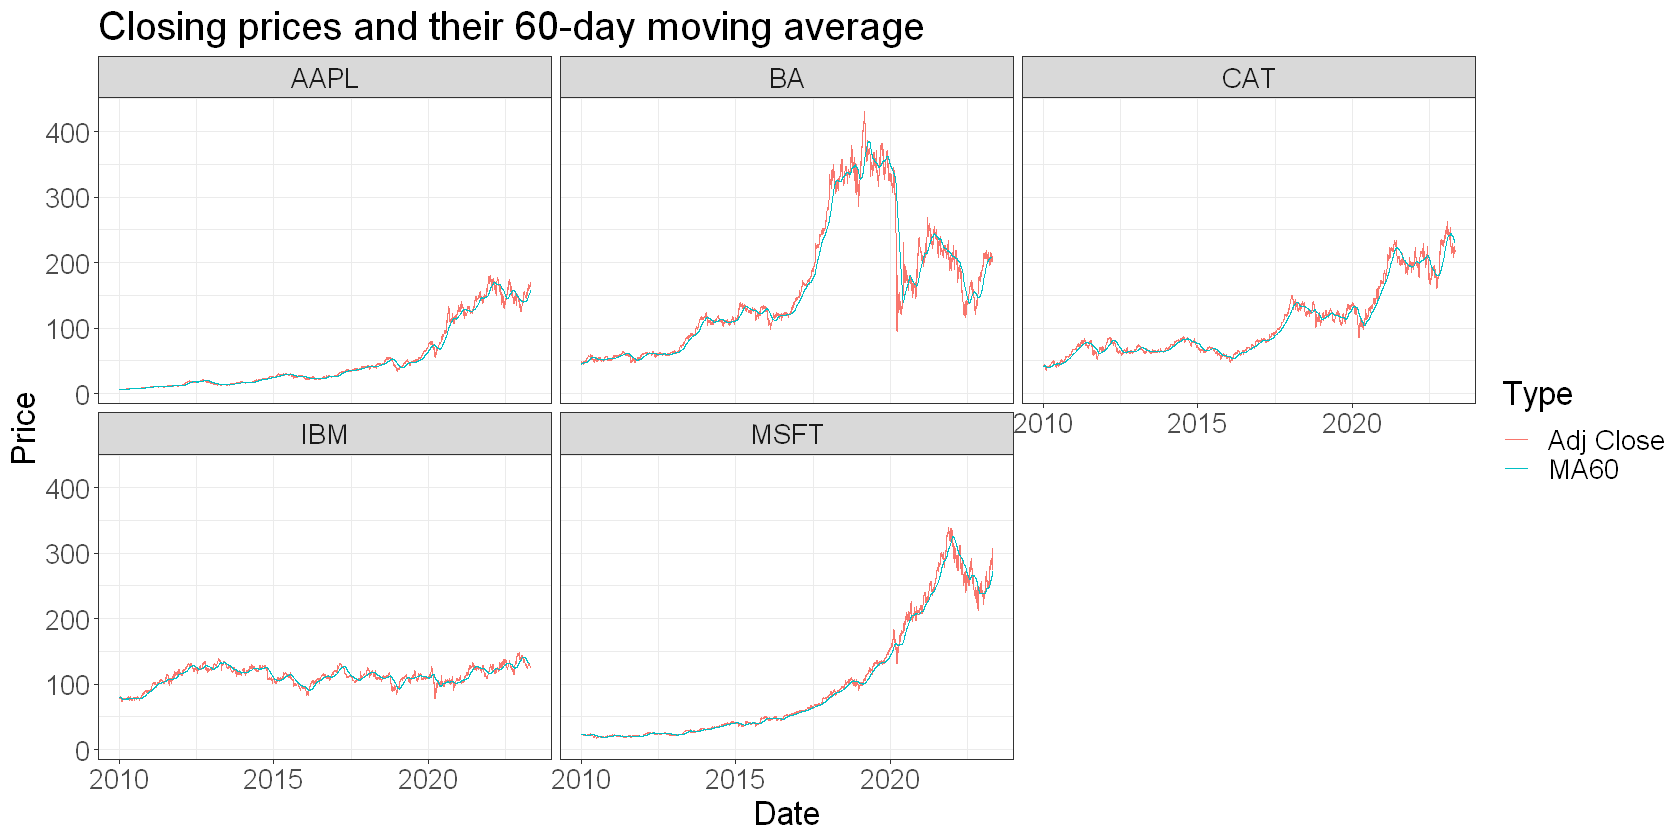

In [59]:
# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

# plot
tbl(con, "prices") %>% 
  select(Date, Ticker, `Adj Close`, MA60) %>% 
  pivot_longer(cols = c(`Adj Close`, MA60), names_to = "Type", values_to = "Price") %>% 
  ggplot(aes(x = Date, y = Price, colour = Type)) +
    geom_line() +
    facet_wrap(~Ticker) +
    labs(title = "Closing prices and their 60-day moving average")

## 6. Want to see the SQL?

Use `show_query` to see the SQL that `dplyr` is executing under the hood:

In [62]:
tbl(con, "prices") %>% 
    dplyr::filter(Date >= "2023-01-01") %>% 
    dplyr::group_by(Ticker) %>% 
    summarise(highest_price = max("Adj Close"), lowest_price = min("Adj Close")) %>% 
    show_query()

<SQL>
SELECT
  Ticker,
  MAX('Adj Close') AS highest_price,
  MIN('Adj Close') AS lowest_price
FROM prices
WHERE (Date >= '2023-01-01')
GROUP BY Ticker


## Conclusion

I hope this article demonstrated just how easy it is to use DuckDB in your analytics workflows. Let me know in the comments if this is something you would use, or are using. 

If you want the notebook that this article is generated from, grab it from GitHub [here](https://github.com/Robot-Wealth/r-quant-recipes/tree/master/duckdb/duckdb_intro_R.ipynb).